# Comparison Example

In this notebook, we show some examples of comparisons between simulations of theoretical models and experimental data, being this the main goal of our software in the long term. This aspect of the NeuralPlayground (NPG) software is still under development. With time, we want to implement tools exclusively made to compare simulated and experimental data, such as a GUI to quickly navigate through the results, add useful metrics to measure the performance of agents or similarity between neural representation, and a "simulation manager" to keep track of the state of all of your runs and available results. For now, this notebook uses the three main modules of NPG, "experiments", "arenas" and "agents", to simulate theoretical models and compare with what is seen in neural recording from real experiments.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import sys
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from neuralplayground.arenas import Wernle2018, MergingRoom, Sargolini2006
from neuralplayground.agents import Weber2018, Stachenfeld2018
from neuralplayground.experiments import Wernle2018Data

Let's start with the Successor Representation model described in our [example notebook](https://github.com/ClementineDomine/NeuralPlayground/tree/main/examples/agent_examples). Here we just compute the eigenvalues of the Successor Representation and show it along side real grid cells from [Sargolini et al. 2006](https://www.science.org/doi/10.1126/science.1125572), with a data handler implemented in our [Experiment class](https://github.com/ClementineDomine/NeuralPlayground/tree/main/neuralplayground/experiments).

In [3]:
env = Sargolini2006(use_behavioral_data=True,
                    time_step_size=0.1,
                    agent_step_size=None)

In [4]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

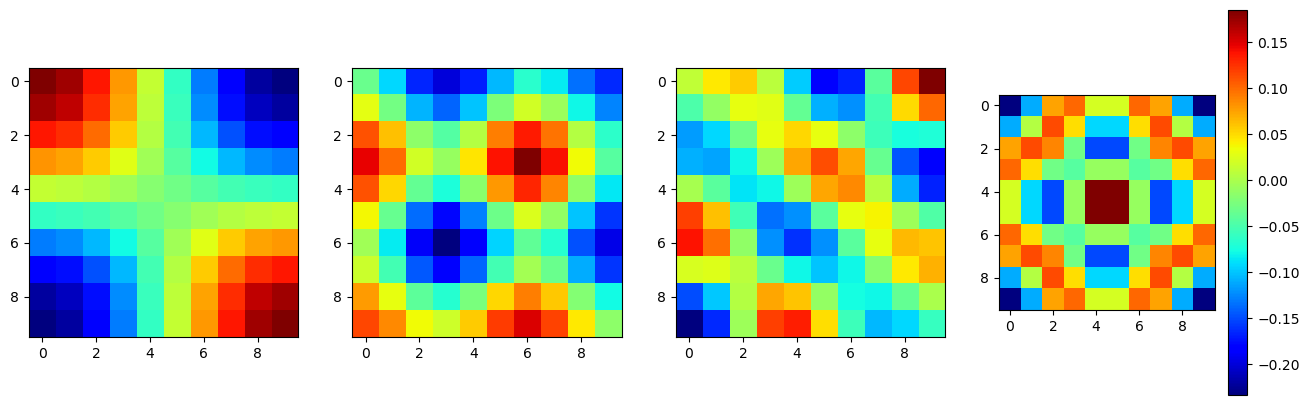

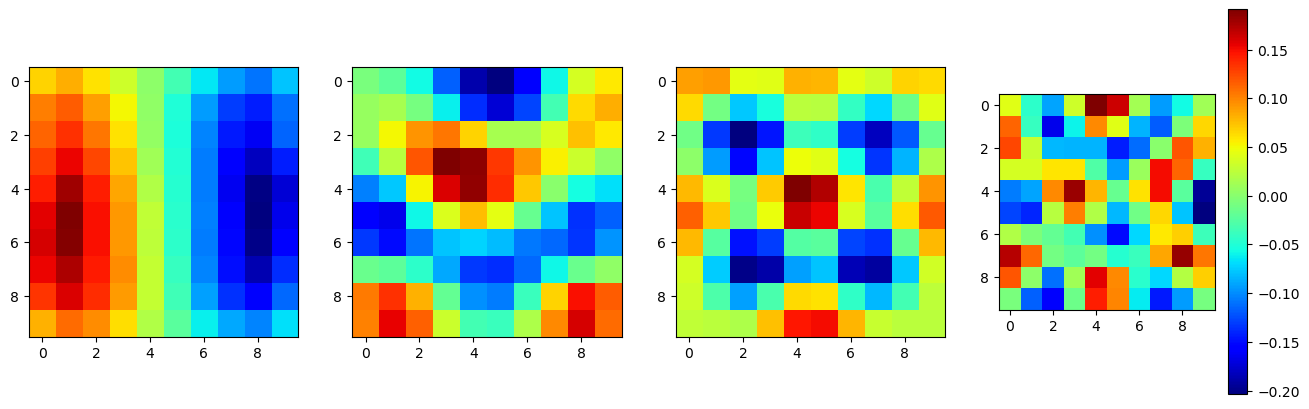

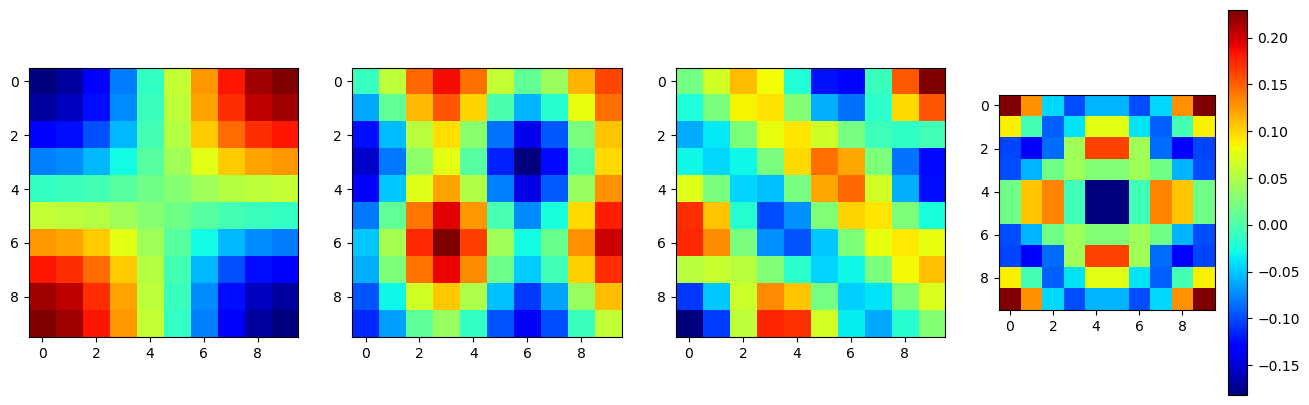

In [5]:
sr = agent.update_successor_rep() # One can compute the successor representation using successive additive update

agent.plot_eigen(sr,eigen=[1,10,15,20], save_path=None)

sr_td = agent.update_successor_rep_td_full() # Compute the successor representation matrix using TD learning
agent.plot_eigen(sr_td, eigen=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_eigen(sr_sum, eigen=[1,10,15,20],save_path=None)


In [6]:
env.show_data()

Dataframe with recordings


,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


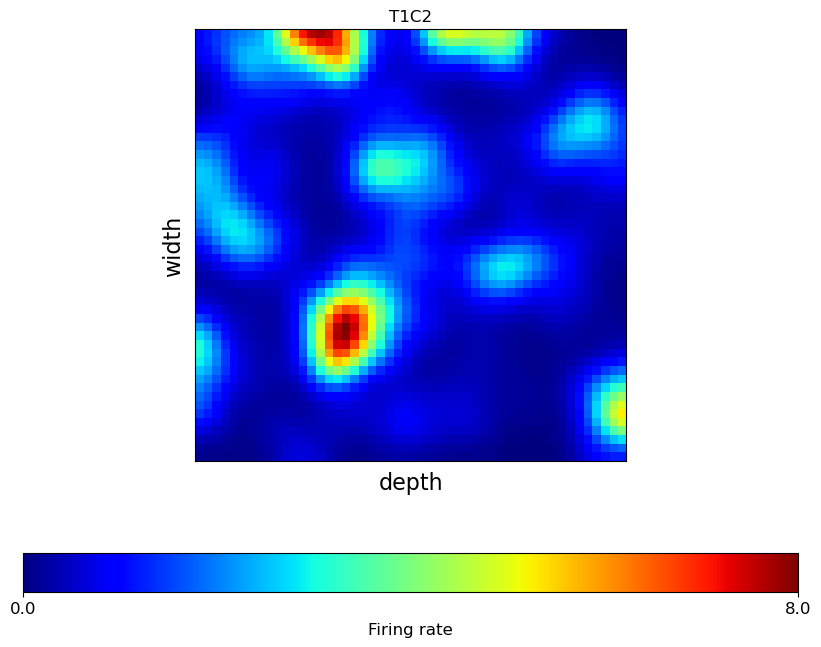

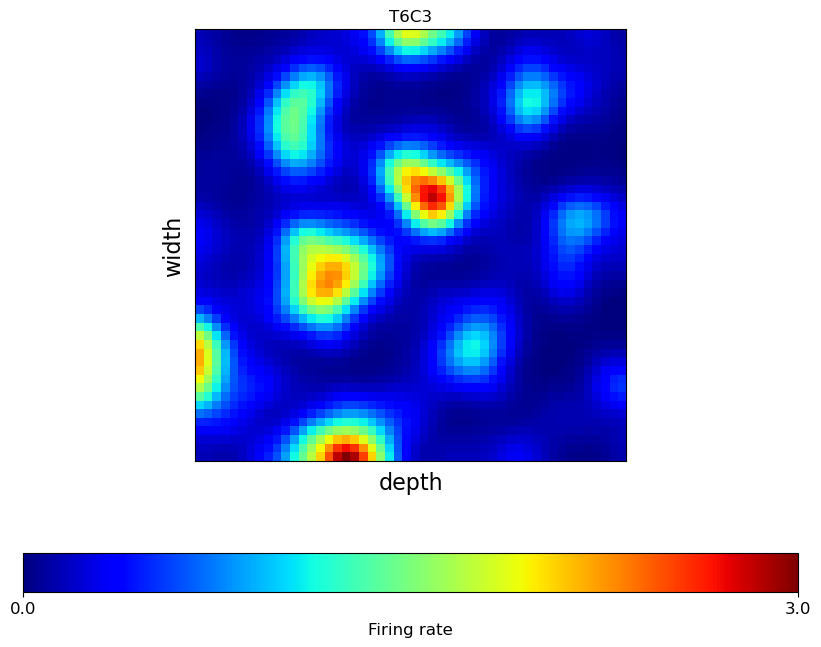

In [7]:
list_of_cells = env.plot_recording_tetr(recording_index = [2, 4], tetrode_id = ["T1C2", "T6C3"])

Now, we present an example using [Weber and Sprekeler 2018](https://elifesciences.org/articles/34560) model, and run it on a simulation that resembles the experimental setting of [Wernle et al. 2018](https://www.nature.com/articles/s41593-017-0036-6). This comparison is also done in their Weber and Sprekeler paper. We are simply showing it as an example of a comparison between results from a theoretical model and real data, which in principle can be done using other theoretical models implemented in the agent class, other arenas and experimental data.

Here, we initialize the environment. In the original experiment, the animal is allowed to explore one room (the one at the bottom in the following plots) for 2.5 hrs, then the animal is moved to the room at the top and allowed to explore for another 2.5 hrs, and finally the wall in between is removed, merging both rooms with the animal exploring it for 5 hrs. Here the main parameters that define the experiments are the ```switch_time```, which is the time in minutes where the agents is moved from one room to another and ```merging_time``` which tells us when the wall in between is changed. These parameters are used to estimate the number of total time steps running the simulation, and the environment itself will take care of the switching of the agent and removal of the wall based on these parameters.

In [8]:
time_step_size = 0.2
merging_time = 270*2.0  # Time in minutes to remove 
switch_time = 270.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 270.0

n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size
fontsize = 16

room_width = [-10,10]
room_depth = [-10,10]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)

print(n_steps)
print(int((merging_time*60)/time_step_size))
print(int((switch_time*60)/time_step_size))

324000.0
162000
81000


Now we initialize the model using some of the parameters described in [original publication](https://elifesciences.org/articles/34560).

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9800/9800 [00:04<00:00, 2130.11it/s]


array([<AxesSubplot: title={'center': 'Exc rates'}>,
       <AxesSubplot: title={'center': 'Inh rates'}>,
       <AxesSubplot: title={'center': 'Out rate'}>], dtype=object)

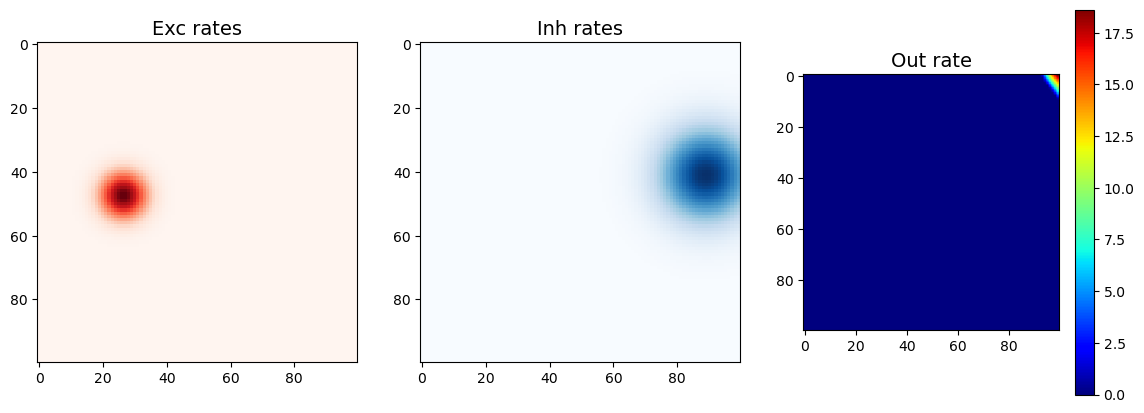

In [9]:
exc_eta = 1.3e-4
inh_eta = 5.3e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 2*4900
Ni = 2*1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.51
agent_step_size = 1.0
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                  Nef=Nef, Nif=Nif, room_width=env.room_width, room_depth=env.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

agent.plot_rates()

Now, we update the parameters of the model using a training loop. Feel free to reduce the time of switch and merging, which gives less number of iterations as a results. To get nice results, run with these parameters and go for a cup of coffee (or two), as it is it will take around 30 minutes (depending on the machine you are using).

In [ ]:
obs, state = env.reset()

for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)
    agent.update()
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        # agent.save_agent("pre_switch.agent")
        # plot rates
        agent.plot_rates()
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.plot_rates()
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

# Use the line below to save the agent and use it later        
# agent.save_agent("post_merge.agent")

  0%|          | 0/324000 [00:00<?, ?it/s]

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)

agent.plot_rates()
plt.savefig("post_merge.pdf", bbox_inches="tight")

Ideally, you should see how some of the bombs in the rate map from each room also merge after removing the wall in between. This can be observed in the original dataset, which is also available in our package! Here we plot some of the rate maps before and after merging the rooms.

In [ ]:
w_data = Wernle2018Data()

In [ ]:
recording_list = w_data.show_data(full_dataframe=False)

In [ ]:
rates = w_data.plot_merging_comparison(session_index=(100, 125, 126, 127))

Note that there are environments that resemble some of the experiments listed in the package, and already load the experimental data. For more details about these please check the notebook examples for the different [arenas availables](https://github.com/ClementineDomine/NeuralPlayground/blob/main/examples/arena_examples/arena_examples.ipynb) and [experimental data](https://github.com/ClementineDomine/NeuralPlayground/blob/main/examples/experimental_examples/experimental_data_examples.ipynb).